In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from dotenv import load_dotenv, find_dotenv
import os
from datetime import date, timedelta

pd.set_option("display.max_columns", None)


In [16]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
FACEIT_PLAYERID = os.environ.get("FACEIT_PLAYERID")


In [17]:
DF_all = pd.read_pickle("./AllDatabz2.pkl", compression="bz2")


In [18]:
DF_all.head()

,index,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
0,87982,35dc17c8-6ca3-41c6-bc6c-e01a51f4c5d6,9,3,23,1,56,10:16,de_mirage,Lose,2016-05-24 11:43:02.394,False,26,736108,2016,5,24
1,87981,35dc17c8-6ca3-41c6-bc6c-e01a51f4c5d6,9,5,20,1,44,16:6,de_dust2,Lose,2016-05-24 12:18:48.669,False,22,736108,2016,5,24
2,37085,dd108e4c-590d-4ab5-b495-7edf146b7c0e,5,2,5,0,20,5:1,de_dust2,Lose,2016-05-24 13:09:32.673,False,6,736108,2016,5,24
3,87980,35dc17c8-6ca3-41c6-bc6c-e01a51f4c5d6,18,6,25,1,44,16:12,de_cache,Win,2016-05-24 13:19:42.652,False,28,736108,2016,5,24
4,87979,35dc17c8-6ca3-41c6-bc6c-e01a51f4c5d6,20,6,19,2,45,16:12,de_mirage,Lose,2016-05-24 14:07:22.922,False,28,736108,2016,5,24


In [19]:
DF_me = DF_all.query("PlayerId == @FACEIT_PLAYERID")
DF_others = DF_all.query("PlayerId != @FACEIT_PLAYERID")

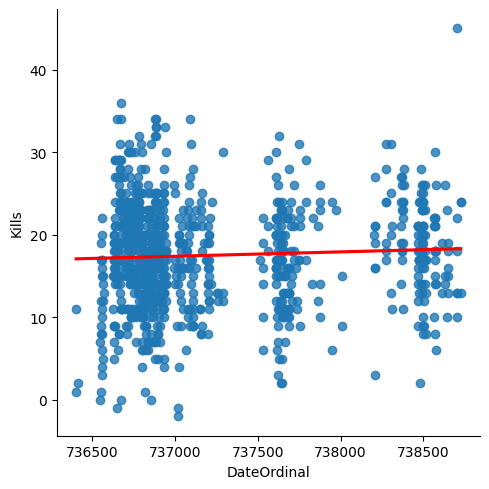

In [61]:
# f, ax = plt.subplots(figsize = (10,6))

g = sns.lmplot(
    data=DF_me,
    x="DateOrdinal",
    y="Kills",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
)
plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Kills over time")

plt.show()


C:\Users\dima1\AppData\Local\Temp\ipykernel_18092\4020954507.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


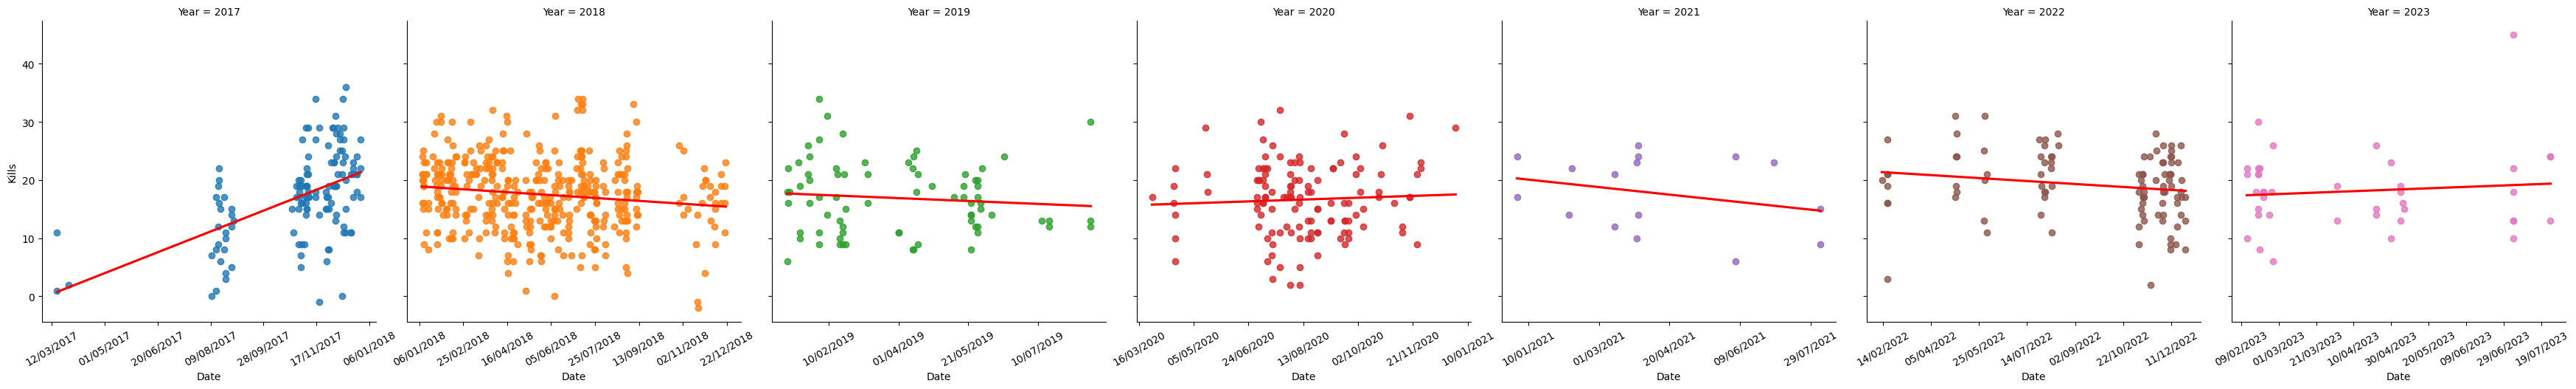

In [21]:
g = sns.lmplot(
    data=DF_me,
    x="DateOrdinal",
    y="Kills",
    ci=None,
    col="Year",
    hue="Year",
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%d/%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    # ax.set_title("Kills over time in 2018")
plt.show()


In [22]:
DF_me.select_dtypes(include=np.number).columns.tolist()
Maps = (
    DF_me.groupby(by="Map")
    .aggregate(
        {
            "Kills": sum,
            "Deaths": sum,
            "Mvps": sum,
            "Map": "count",
            "Headshots%": "mean",
            "Result": lambda x: pd.value_counts(x)[0],
        }
    )
    .rename({"Map": "TimesPlayed"}, axis=1)
)


In [23]:
Maps["WinRate%"] = (Maps["Result"] / Maps["TimesPlayed"] * 100).astype(int)


In [24]:
Maps.sort_values(by="TimesPlayed", inplace=True, ascending=False)
Maps["K/D"] = round(Maps["Kills"] / Maps["Deaths"], 2)


In [25]:
def func(pct, allvalues):
    absolute = max(int(pct / 100 * np.sum(allvalues)), 1)
    return "{:.1f}%\n({:d} games)".format(pct, absolute)


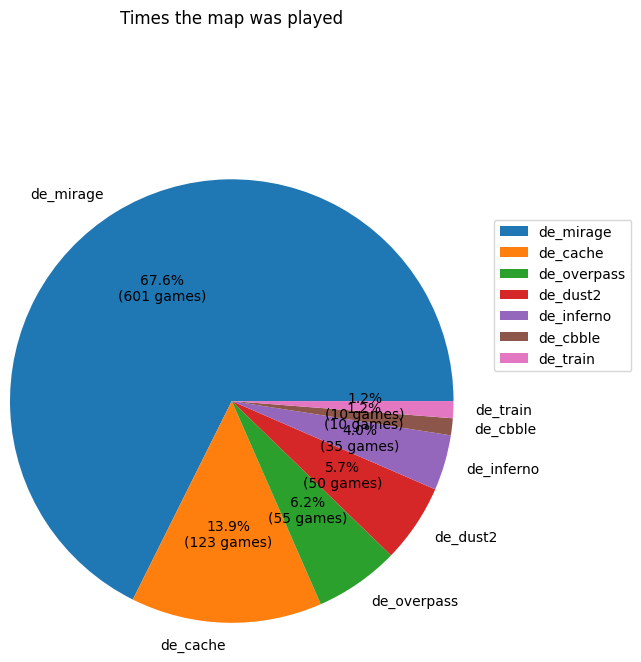

In [26]:
fig, ax = plt.subplots()
data = Maps.query("TimesPlayed > 10")["TimesPlayed"]
p, tx, autotexts = ax.pie(
    data, labels=data.index, autopct=lambda pct: func(pct, data), radius=1.5
)
ax.xaxis.set_label_position("top")
ax.set_title("Times the map was played", y=1.5)

plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()


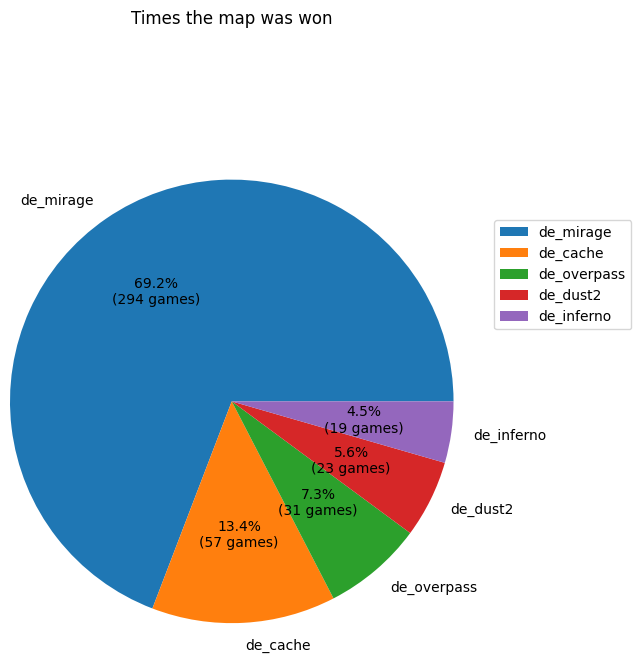

In [27]:
fig, ax = plt.subplots()
data = Maps.query("Result > 10")["Result"]

ax.pie(
    data,
    labels=data.index,
    autopct=lambda pct: func(pct, data),
    radius=1.5,
)
ax.xaxis.set_label_position("top")
ax.set_title("Times the map was won", y=1.5)
plt.legend(bbox_to_anchor=(1.6, 1.01))
plt.show()


In [28]:
def heatmap(data, title=""):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(corr.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=45)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr.columns)
    ax.set_yticklabels(corr.columns)

    matrix = pd.DataFrame(data.corr(method="pearson")).round(2)
    for i in range(len(matrix)):
        for j in range(len(matrix.iloc[0])):
            text = ax.text(j, i, matrix.iloc[i, j], ha="center", va="center", color="w")
    ax.set_title(title, pad=20)


C:\Users\dima1\AppData\Local\Temp\ipykernel_18092\2157301004.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()
C:\Users\dima1\AppData\Local\Temp\ipykernel_18092\2157301004.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = pd.DataFrame(data.corr(method="pearson")).round(2)


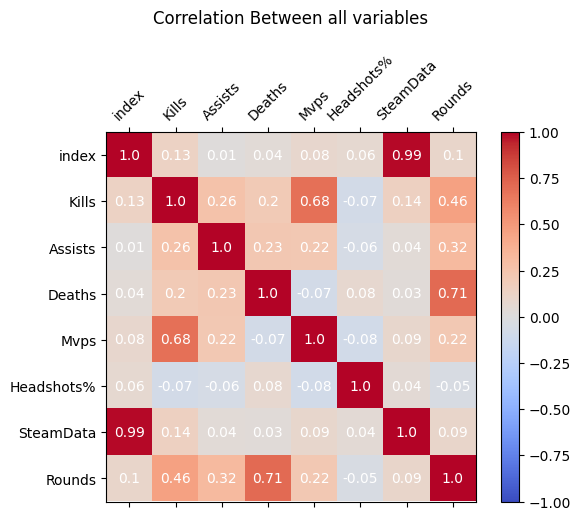

In [29]:
heatmap(
    DF_me.drop(columns=["Year", "Month", "Day", "DateOrdinal"]),
    title="Correlation Between all variables",
)
# there is a correlation between installs and rating count -> more people installs leads to more people commenting
# next to no correlaiton between everything


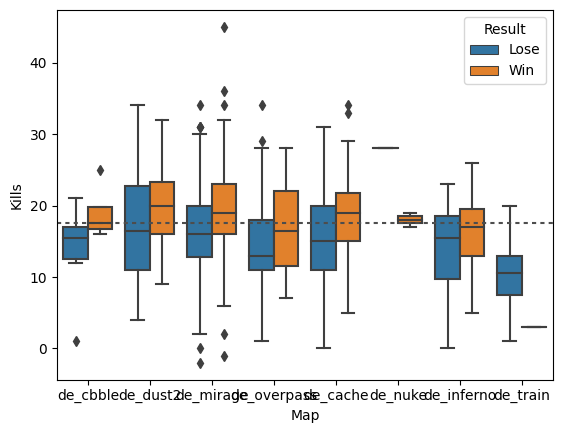

In [30]:
mean = DF_me["Kills"].mean()

ax = sns.boxplot(
    data=DF_me.query("Result in ['Lose', 'Win']"), y="Kills", x="Map", hue="Result"
)
ax.axhline(mean, color=".3", dashes=(2, 2))
plt.show()


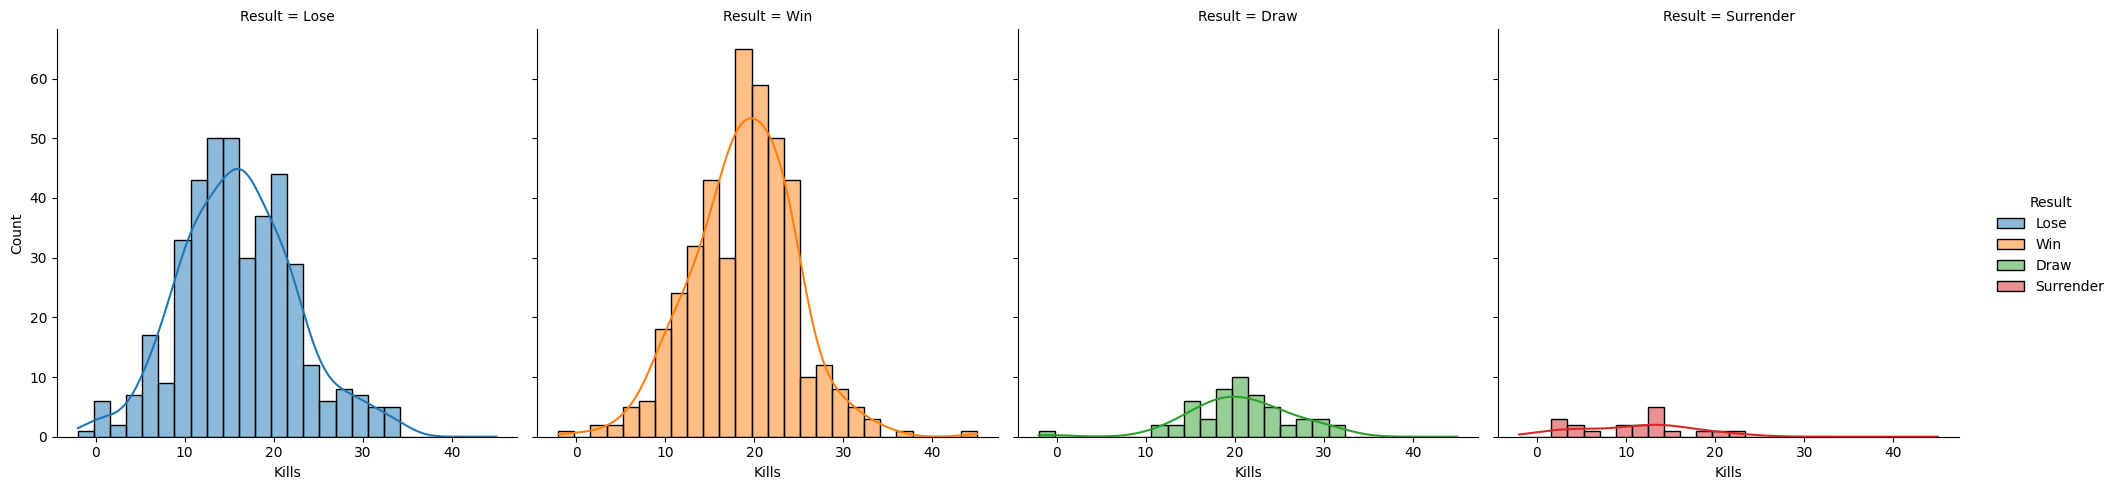

In [31]:
sns.displot(
    data=DF_me,
    x="Kills",
    col="Result",
    hue="Result",
    kde=True,
    facet_kws=dict(sharex=False, sharey=True),
)


In [32]:
def count_wins(x):
    wins = pd.value_counts(x).get("Win")
    if wins:
        return wins
    else:
        return 0


In [33]:
YearlyData = (
    DF_me.groupby(["Year", "Month"], as_index=False)
    .aggregate(
        {
            "Kills": "sum",
            "Assists": "sum",
            "Deaths": "sum",
            "Headshots%": "mean",
            "Map": "count",
            "Result": lambda x: count_wins(x),
        }
    )
    .rename({"Map": "TimesPlayed", "Result": "TimesWon"}, axis=1)
)


In [34]:
YearlyData.head()


,Year,Month,Kills,Assists,Deaths,Headshots%,TimesPlayed,TimesWon
0,2017,3,14,6,54,75.666667,3,0
1,2017,8,264,108,408,33.208333,24,10
2,2017,10,106,33,124,48.285714,7,3
3,2017,11,833,180,714,43.812500,48,22
4,2017,12,1023,232,743,40.333333,48,27


In [35]:
YearlyData["WinRate"] = (
    YearlyData["TimesWon"] / YearlyData["TimesPlayed"] * 100
).astype(int)


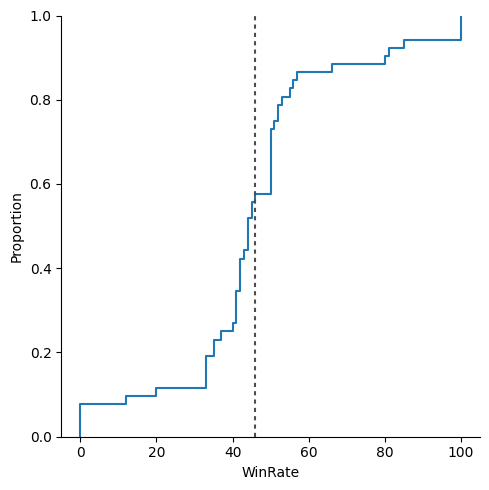

In [36]:
winrate = YearlyData["WinRate"].mean()
g = sns.displot(data=YearlyData, x="WinRate", kind="ecdf")
for ax in g.axes.flat:
    ax.axvline(x=winrate, color=".3", dashes=(2, 2))
plt.show()


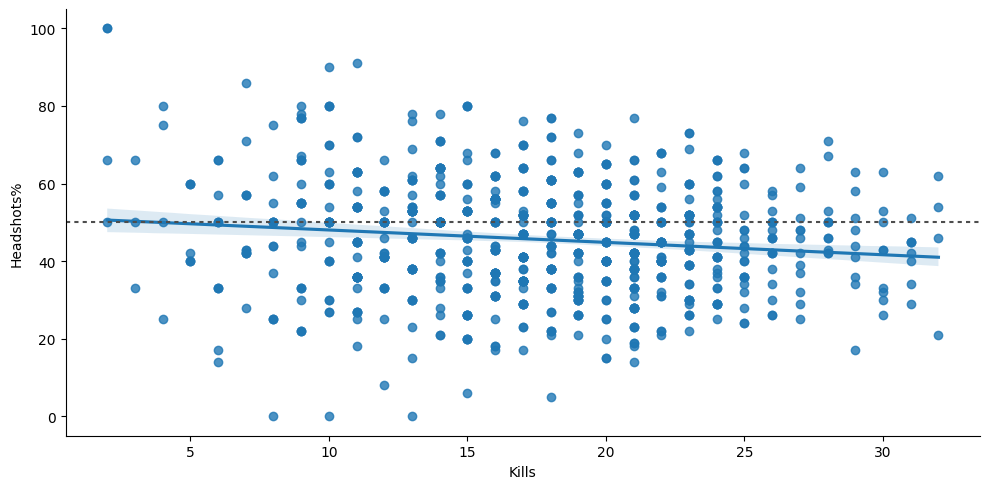

In [37]:
q_low = DF_me["Kills"].quantile(0.01)
q_hi = DF_me["Kills"].quantile(0.99)

DF_filtered = DF_me[(DF_me["Kills"] < q_hi) & (DF_me["Kills"] > q_low)]
g = sns.lmplot(data=DF_filtered, y="Headshots%", x="Kills", aspect=2)
for ax in g.axes.flat:
    ax.axhline(50, color=".3", dashes=(2, 2))
plt.show()


C:\Users\dima1\AppData\Local\Temp\ipykernel_18092\4081343408.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


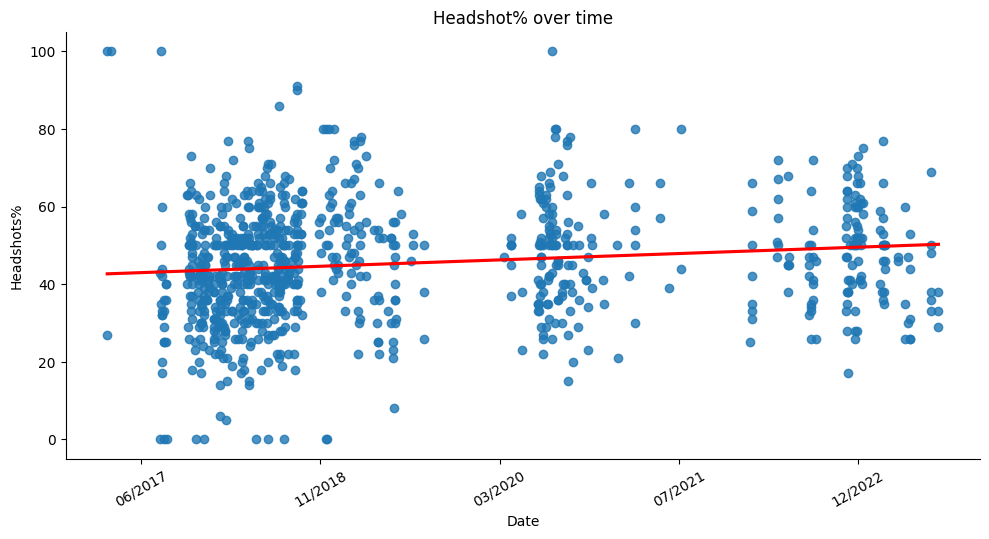

In [38]:
g = sns.lmplot(
    data=DF_me,
    x="DateOrdinal",
    y="Headshots%",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=2,
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Headshot% over time")
plt.show()


In [39]:
DF_me[DF_me["Headshots%"] > 95]


,index,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
7184,392493,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,1,0,10,0,100,11:1,de_cbble,Lose,2017-03-17 13:00:31.295,False,12,736405,2017,3,17
7909,392491,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2,0,18,0,100,2:16,de_mirage,Lose,2017-03-28 05:56:43.670,False,18,736416,2017,3,28
18018,392487,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,1,0,6,1,100,1:9,de_overpass,Lose,2017-08-14 07:24:37.963,False,10,736555,2017,8,14
253743,397114,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,2,2,12,0,100,12:1,de_inferno,Surrender,2020-08-10 17:11:37.000,True,13,737647,2020,8,10


C:\Users\dima1\AppData\Local\Temp\ipykernel_18092\4107117230.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels, rotation=30)


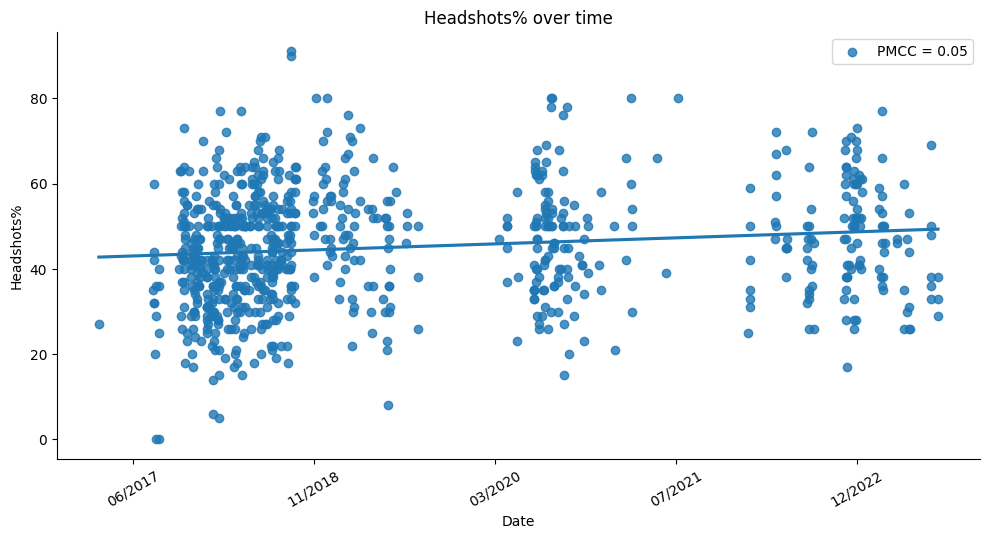

In [40]:
data = DF_me[DF_me["Kills"] >= 10]

g = sns.lmplot(
    data=data,
    x="DateOrdinal",
    y="Headshots%",
    ci=0,
    facet_kws=dict(sharex=False, sharey=True),
    aspect=2,
)
# plt.title("Kills over time")
for ax in g.axes.flat:
    new_labels = [
        date.fromordinal(int(item)).strftime("%m/%Y") for item in ax.get_xticks()
    ]

    ax.collections[0].set_label(
        f'PMCC = {np.corrcoef(DF_me["Kills"], DF_me["DateOrdinal"])[0,1]:.2f}'
    )
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_xlabel("Date")
    ax.set_title("Headshots% over time")
    ax.legend()
# plt.show()


Text(20.513422818791945, 288, 'mean: 18')

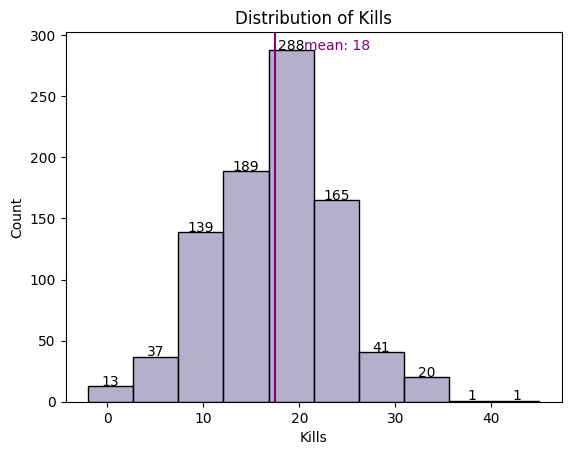

In [41]:
ax = sns.histplot(DF_me["Kills"], color="#9d94ba", bins=10, kde=False)
ax.set(title="Distribution of Kills")
# label each bar in histogram
for p in ax.patches:
    height = p.get_height()  # get the height of each bar
    # adding text to each bar
    ax.text(
        x=p.get_x()
        + (
            p.get_width() / 2
        ),  # x-coordinate position of data label, padded to be in the middle of the bar
        y=height + 0.2,  # y-coordinate position of data label, padded 0.2 above bar
        s="{:.0f}".format(height),  # data label, formatted to ignore decimals
        ha="center",
    )

plt.axvline(DF_me["Kills"].mean(), color="purple", label="mean")
# adding data label to mean line
plt.text(
    x=DF_me["Kills"].mean()
    + 3,  # x-coordinate position of data label, adjusted to be 3 right of the data point
    y=max(
        [h.get_height() for h in ax.patches]
    ),  # y-coordinate position of data label, to take max height
    s="mean: {:.0f}".format(DF_me["Kills"].mean()),  # data label
    color="purple",
)  # colour


# https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9


C:\Users\dima1\AppData\Roaming\Python\Python39\site-packages\seaborn\categorical.py:3544: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='Map', ylabel='Headshots%'>

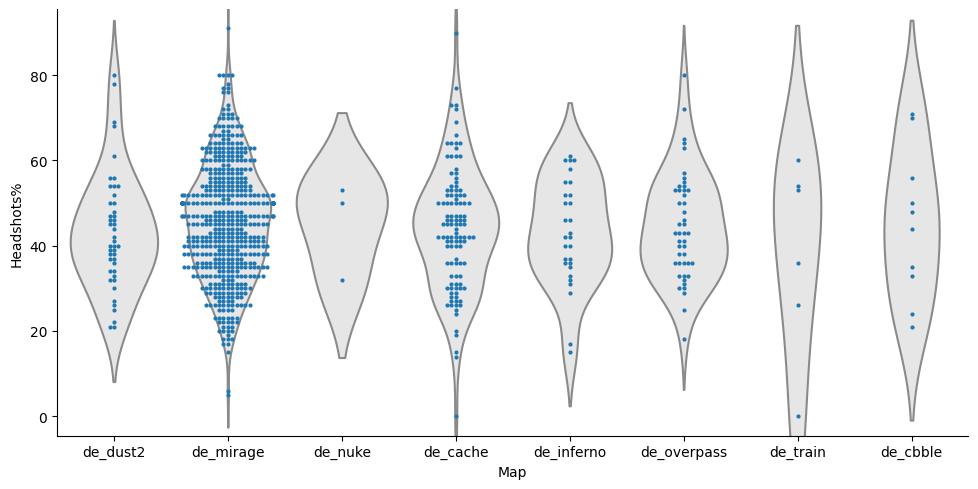

In [42]:
data = DF_me[(DF_me["Kills"] >= 10) & (DF_me["Result"] != "Surrender")]
# sns.catplot(
#     data = data,
#     x = "Map",
#     y = "Headshots%",
#     kind = "box",
#     aspect=1.5,
# )

sns.catplot(
    data=data, x="Map", y="Headshots%", kind="violin", color=".9", inner=None, aspect=2
)
sns.swarmplot(data=data, x="Map", y="Headshots%", size=3)


In [43]:
data


,index,PlayerId,Kills,Assists,Deaths,Mvps,Headshots%,Score,Map,Result,CreatedAt,SteamData,Rounds,DateOrdinal,Year,Month,Day
7195,392492,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,11,6,26,0,27,16:14,de_dust2,Lose,2017-03-17 13:46:49.379,False,30,736405,2017,3,17
18013,392488,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,17,8,21,3,35,14:16,de_mirage,Win,2017-08-14 07:05:32.910,False,30,736555,2017,8,14
18454,392485,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,19,2,21,2,32,14:16,de_nuke,Win,2017-08-16 07:47:50.484,False,30,736557,2017,8,16
18465,392484,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,12,6,19,2,42,16:10,de_mirage,Win,2017-08-16 08:35:16.177,False,26,736557,2017,8,16
18746,392482,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,22,13,22,1,32,19:17,de_dust2,Lose,2017-08-17 10:00:04.461,False,36,736558,2017,8,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390844,397323,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,45,7,15,8,48,13:16,de_mirage,Win,2023-07-04 14:45:58.000,True,29,738705,2023,7,4
390849,397324,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,18,2,4,4,33,16:1,de_mirage,Win,2023-07-04 15:43:26.000,True,17,738705,2023,7,4
392568,397325,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,24,8,18,3,33,16:12,de_mirage,Win,2023-07-24 12:47:49.000,True,28,738725,2023,7,24
392577,397326,2fb9fe10-5c7e-4f2f-860b-a9ee2f88801a,13,6,14,3,38,5:16,de_mirage,Win,2023-07-24 14:43:01.000,True,21,738725,2023,7,24


In [44]:
Maps


,Kills,Deaths,Mvps,TimesPlayed,Headshots%,Result,WinRate%,K/D
Map,,,,,,,,
de_mirage,10753,10013,1469,602,45.875415,294,48,1.07
de_cache,2153,2144,280,124,44.274194,57,45,1.00
de_overpass,872,946,110,55,45.363636,31,56,0.92
de_dust2,953,868,133,51,43.490196,24,47,1.10
de_inferno,549,564,66,36,42.638889,19,52,0.97
de_cbble,190,194,26,11,50.181818,6,54,0.98
de_train,107,195,9,11,41.545455,10,90,0.55
de_nuke,80,80,11,4,47.500000,2,50,1.00


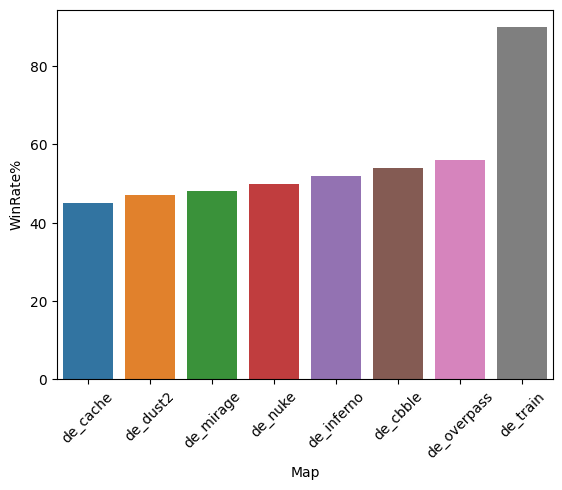

In [45]:
sns.barplot(
    data=Maps,
    x=Maps.index,
    y=Maps["WinRate%"],
    order=Maps.sort_values(by="WinRate%").index,
)
plt.xticks(rotation=45)
plt.show()


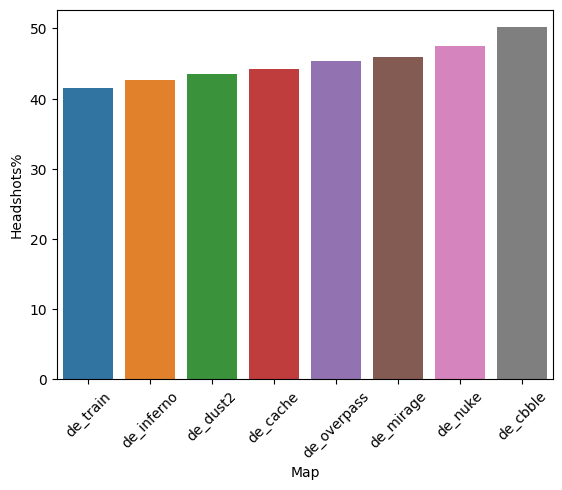

In [46]:
sns.barplot(
    data=Maps,
    x=Maps.index,
    y=Maps["Headshots%"],
    order=Maps.sort_values(by="Headshots%").index,
)
plt.xticks(rotation=45)
plt.show()


<AxesSubplot: xlabel='Map', ylabel='TimesPlayed'>

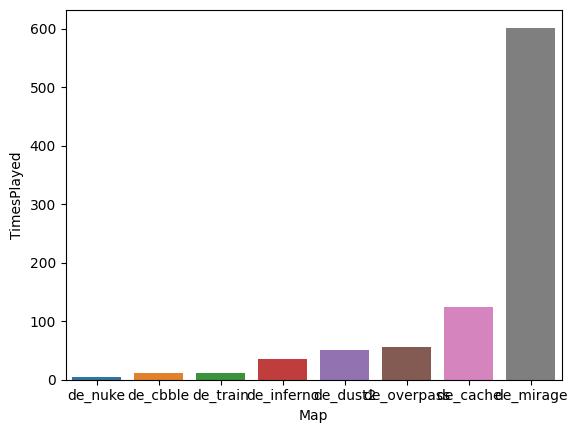

In [47]:
sns.barplot(
    data=Maps,
    y="TimesPlayed",
    x=Maps.index,
    order=Maps.sort_values(by="TimesPlayed").index,
)


<AxesSubplot: xlabel='Map', ylabel='WinRate%'>

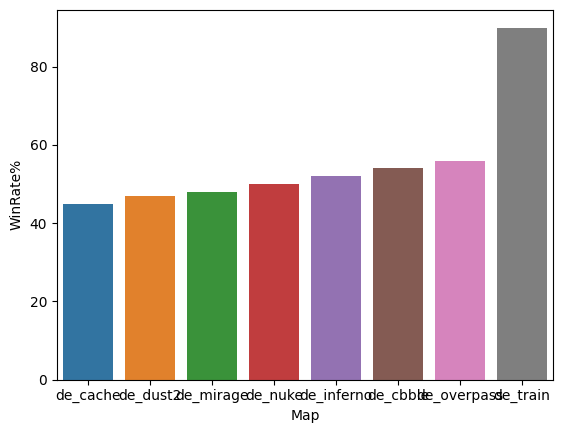

In [48]:
sns.barplot(
    data=Maps, y="WinRate%", x=Maps.index, order=Maps.sort_values(by="WinRate%").index
)


In [49]:
DF_me["K/D"] = DF_me["Kills"] / DF_me["Deaths"]
DF_me["K/A"] = DF_me["Kills"] / DF_me["Assists"]


C:\Users\dima1\AppData\Local\Temp\ipykernel_18092\193573094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_me["K/D"] = DF_me["Kills"] / DF_me["Deaths"]
C:\Users\dima1\AppData\Local\Temp\ipykernel_18092\193573094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_me["K/A"] = DF_me["Kills"] / DF_me["Assists"]


In [50]:
DF_me.reset_index(inplace=True)


In [51]:
data = DF_me.query("Rounds > 16").drop("index", axis=1).reset_index(drop=False)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data[~data["K/D"].isna()].copy()


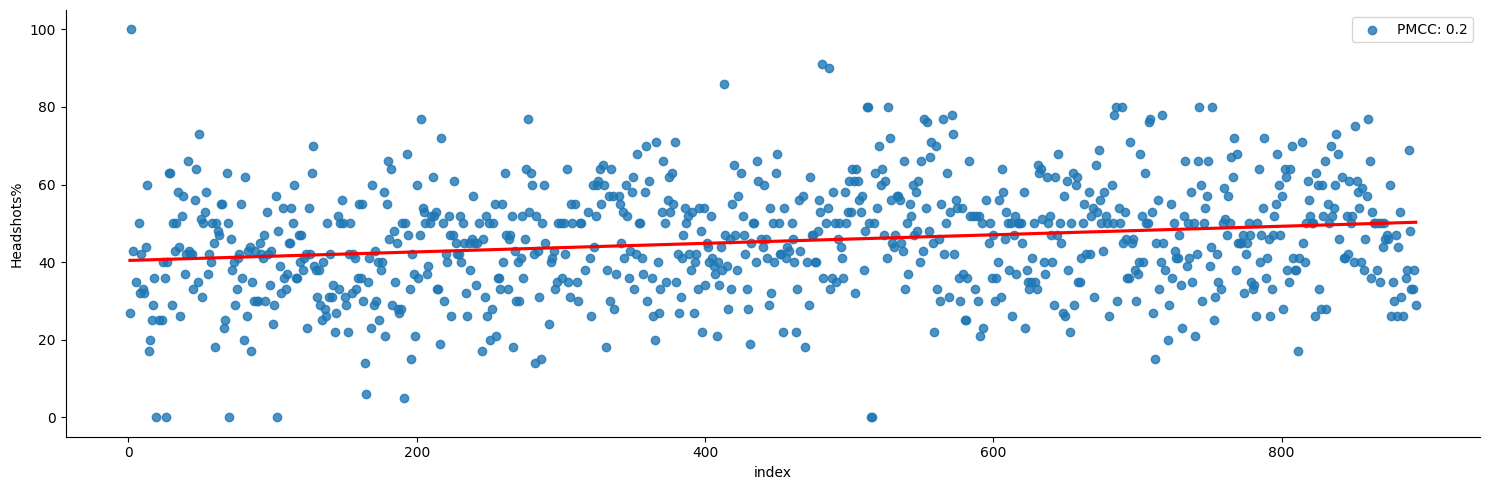

In [52]:
g = sns.lmplot(
    data=data,
    x="index",
    y="Headshots%",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=3,
    legend=True,
    # hue = "Result"
)
g.axes[0][0].axes.collections[0].set_label(
    f"PMCC: {round(np.corrcoef(data['index'], data['Headshots%'])[0,1], 2)}"
)
plt.tight_layout()
plt.legend()
plt.show()


In [53]:
# data = DF[(DF["K/D"] != np.inf)].drop("index", axis = 1).reset_index(drop = False)
# data.replace([np.inf, -np.inf], np.nan, inplace=True)


In [54]:
# data = data[~data["K/D"].isna()].copy()


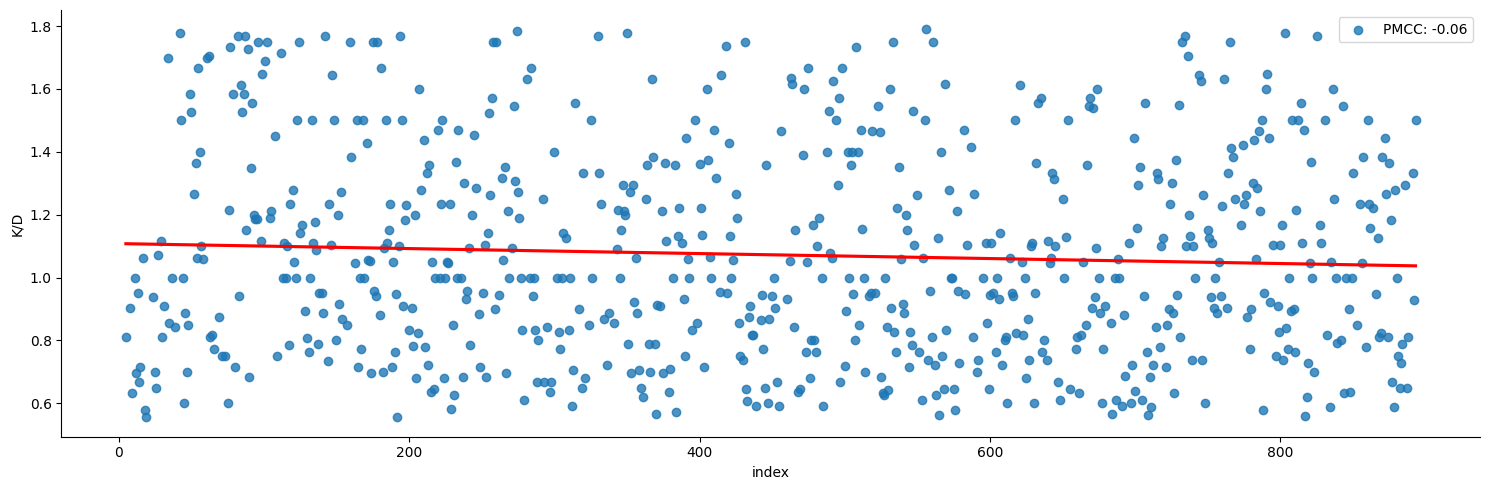

In [55]:
q_low = DF_me["K/D"].quantile(0.1)
q_hi = DF_me["K/D"].quantile(0.9)

DF_filtered = data[(data["K/D"] < q_hi) & (data["K/D"] > q_low)]
g = sns.lmplot(
    data=DF_filtered,
    x="index",
    y="K/D",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=3,
    legend=True,
)
g.axes[0][0].axes.collections[0].set_label(
    f"PMCC: {round(np.corrcoef(DF_filtered.index, DF_filtered['K/D'])[0,1], 2)}"
)
plt.tight_layout()
plt.legend()
plt.show()


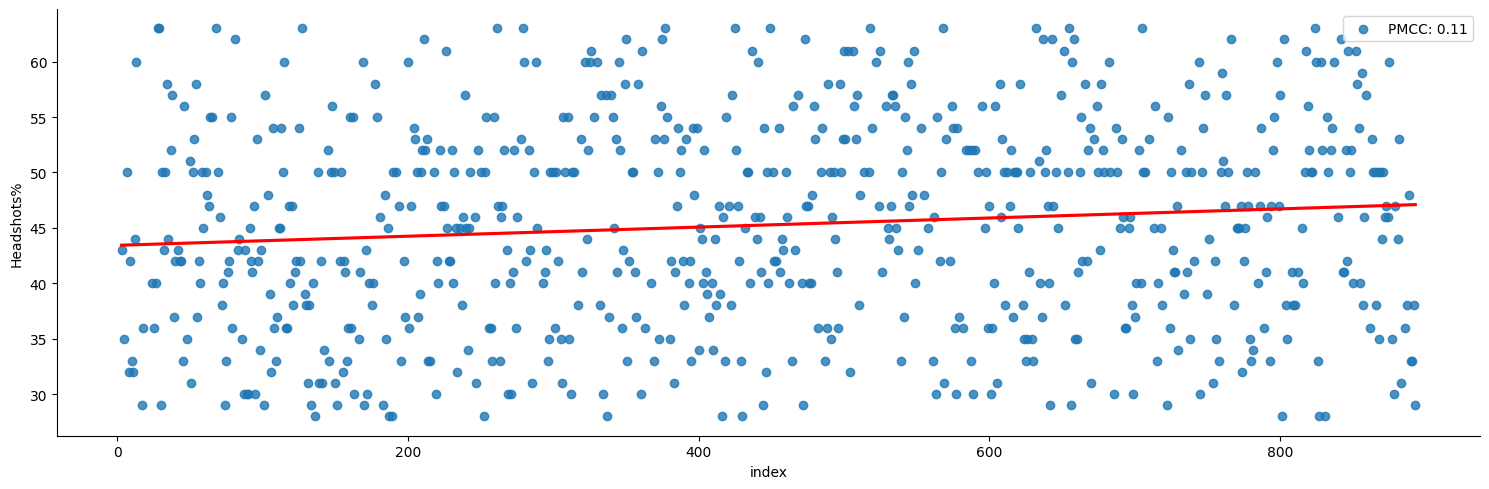

In [56]:
q_low = DF_me["Headshots%"].quantile(0.1)
q_hi = DF_me["Headshots%"].quantile(0.9)

DF_filtered = data[(data["Headshots%"] < q_hi) & (data["Headshots%"] > q_low)]
g = sns.lmplot(
    data=DF_filtered,
    x="index",
    y="Headshots%",
    ci=0,
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
    aspect=3,
    legend=True,
)
g.axes[0][0].axes.collections[0].set_label(
    f"PMCC: {round(np.corrcoef(DF_filtered.index, DF_filtered['Headshots%'])[0,1], 2)}"
)
plt.tight_layout()
plt.legend()
plt.show()


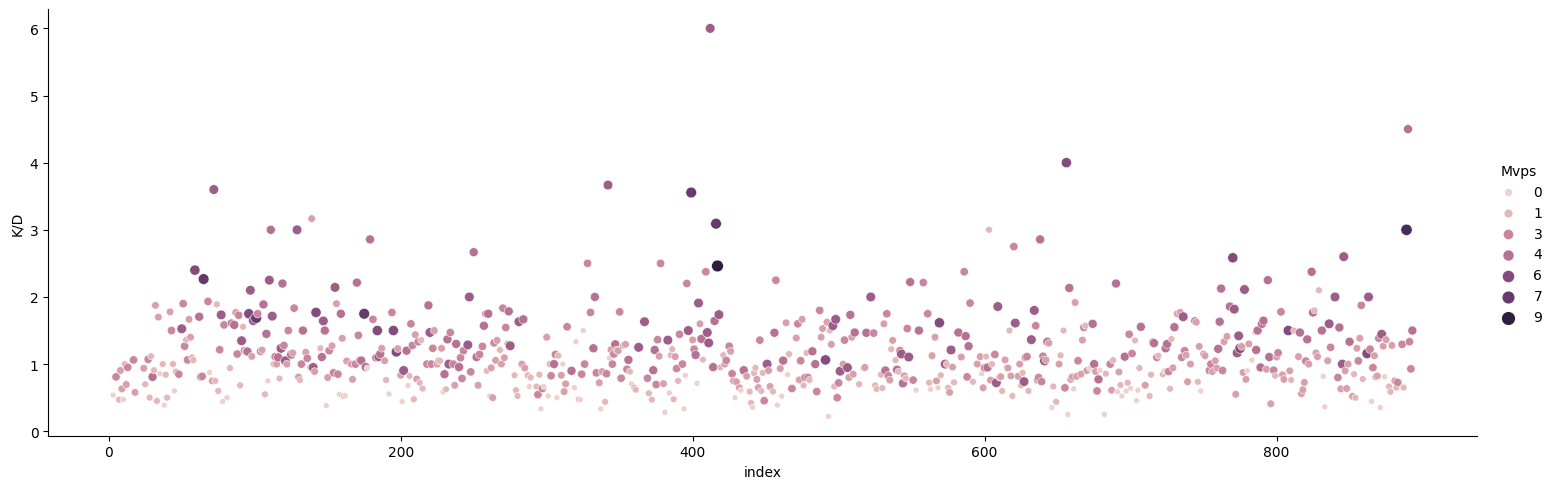

In [57]:
sns.relplot(data=DF_filtered, x="index", y="K/D", hue="Mvps", aspect=3, size="Mvps")


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'de_dust2'),
  Text(1, 0, 'de_mirage'),
  Text(2, 0, 'de_overpass'),
  Text(3, 0, 'de_cache'),
  Text(4, 0, 'de_nuke'),
  Text(5, 0, 'de_inferno'),
  Text(6, 0, 'de_train'),
  Text(7, 0, 'de_cbble')])

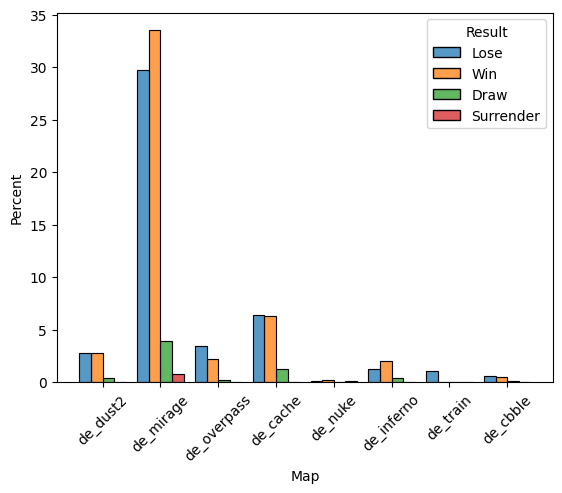

In [58]:
sns.histplot(
    data=data,
    x="Map",
    hue="Result",
    multiple="dodge",
    shrink=0.8,
    stat="percent",
    discrete=True,
)
plt.xticks(rotation=45)


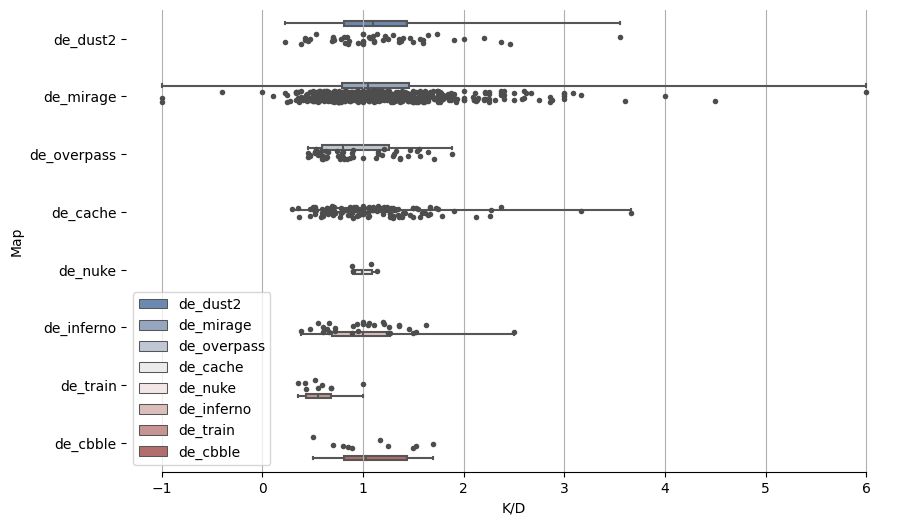

In [59]:
# sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 6))
# ax.set_xscale("log")

# Load the example planets dataset
# planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(data, x="K/D", y="Map", hue="Map", whis=[0, 100], width=0.6, palette="vlag") # type: ignore

# Add in points to show each observation
sns.stripplot(data, x="K/D", y="Map", size=4, color=".3")

# # Tweak the visual presentation
ax.xaxis.grid(True)
# ax.set(ylabel="")
sns.despine(trim=True, left=True)


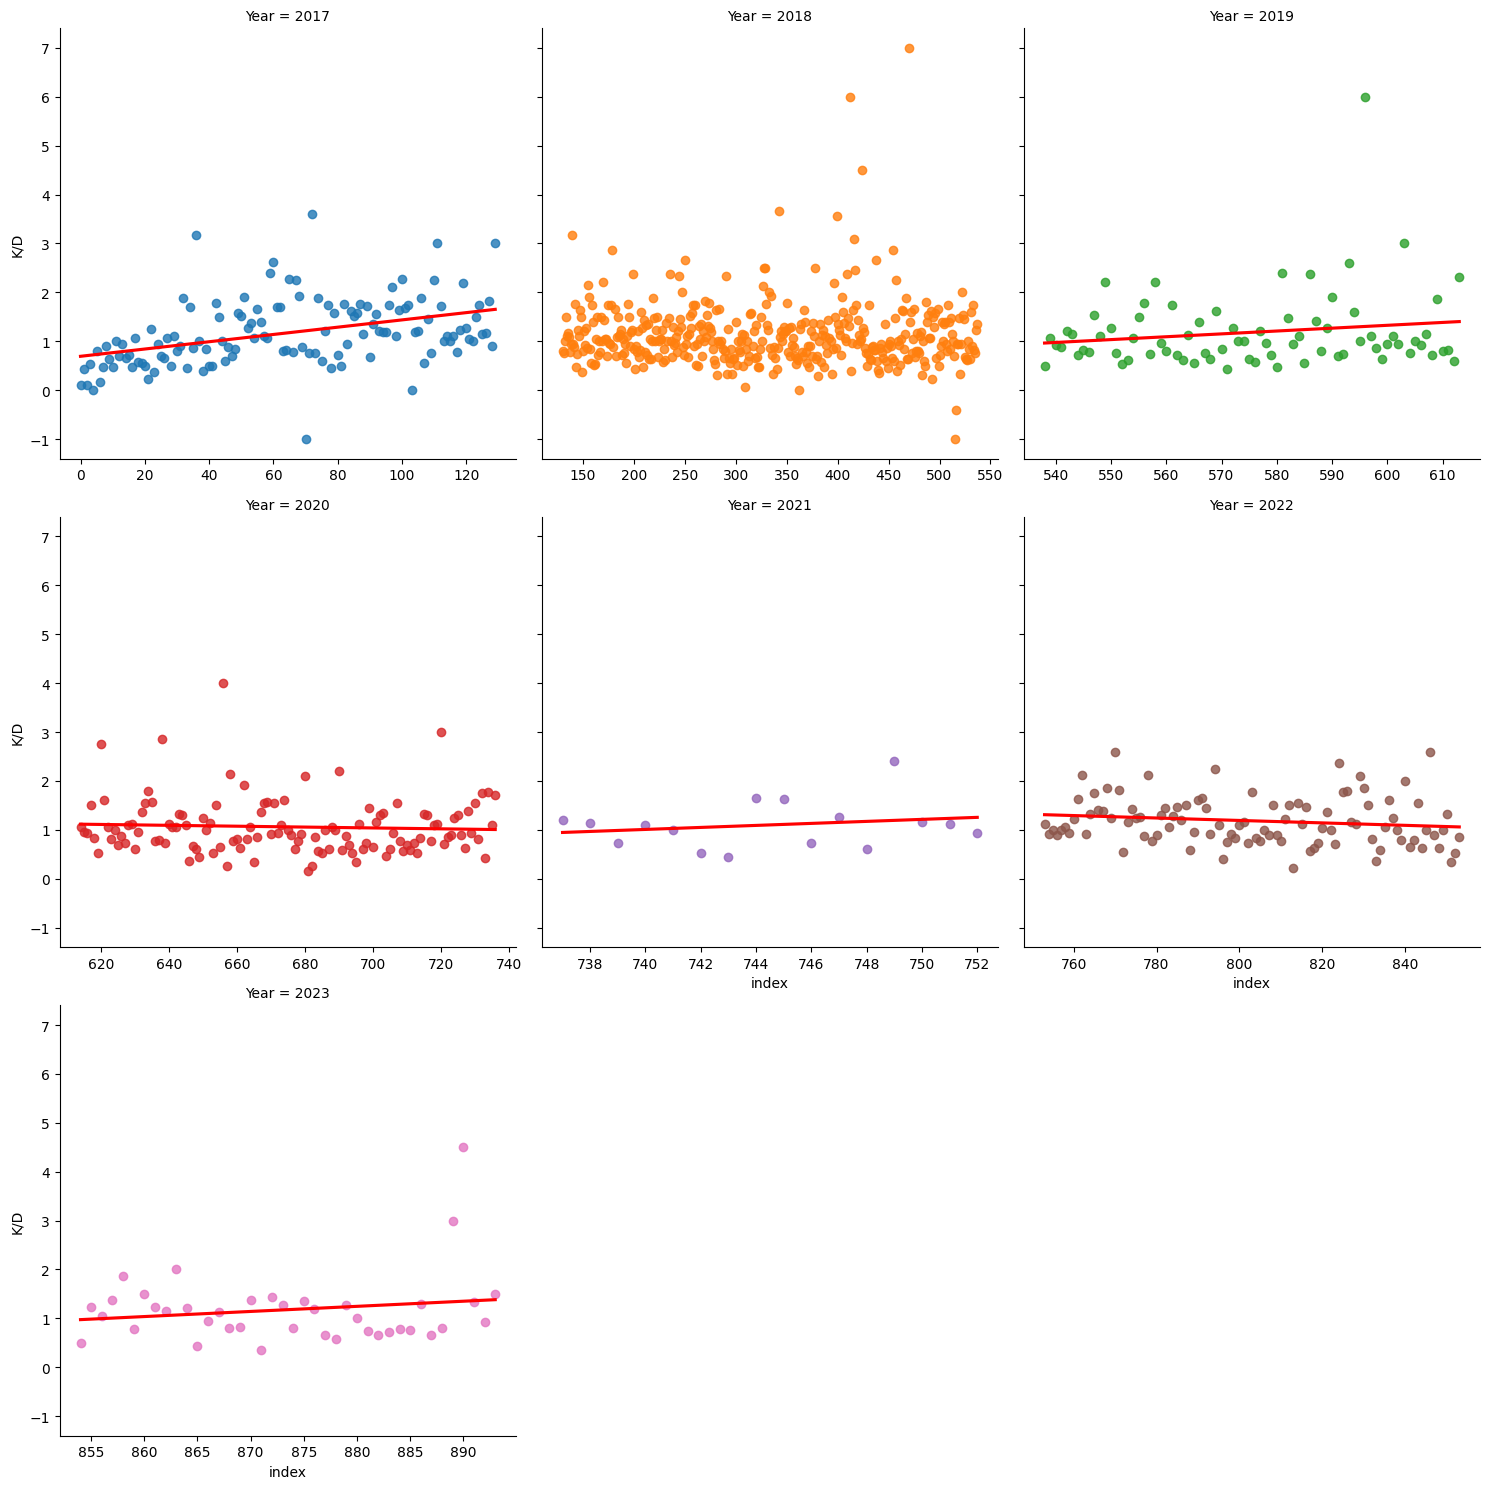

In [60]:
g = sns.lmplot(
    data=DF_me.drop(columns="index").reset_index(drop=False),
    x="index",
    y="K/D",
    ci=0,
    col="Year",
    col_wrap=3,
    hue="Year",
    line_kws={"color": "red"},
    facet_kws=dict(sharex=False, sharey=True),
)
